In [1]:
import optuna
import MTM
from MTM import matchTemplates, drawBoxesOnRGB
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time
import joblib
import json
import numpy as np

In [2]:
def randomcrop(img, scale=None):
    '''
    ### Random Crop ###
    img: image
    scale: percentage of cropped area
    '''
    if scale == None:
        return img, 0, 0
    # Crop image
    height, width = int(img.shape[0]*scale), int(img.shape[1]*scale)
    x = random.randint(0, img.shape[1] - int(width))
    y = random.randint(0, img.shape[0] - int(height))
    cropped = img[y:y+height, x:x+width]
    resized = cv2.resize(cropped, (img.shape[1], img.shape[0]))

    return resized, x, y

def cutout(img, amount=None):
    '''
    ### Cutout ###
    img: image
    gt_boxes: format [[obj x1 y1 x2 y2],...]
    amount: num of masks / num of objects 
    '''
    if amount == None:
        return img
    
    out = img.copy()
    height, width = int(img.shape[0]*amount), int(img.shape[1]*amount)
    x = random.randint(0, img.shape[1] - int(width))
    y = random.randint(0, img.shape[0] - int(height))
    cv2.rectangle(out, (x, y), (x+width, y+height), (255, 255, 255), thickness=-1)
    
    return out

def colorjitter(img, cj_type=None):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == None:
        return img
    
    elif cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img
    
def noisy(img, noise_type=None):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == None:
        return img
    
    elif noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image
    
def filters(img, f_type = "blur"):
    '''
    ### Filtering ###
    img: image
    f_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if f_type == None:
        return img
    
    elif f_type == "blur":
        image=img.copy()
        fsize = 9
        return cv2.blur(image,(fsize,fsize))
    
    elif f_type == "gaussian":
        image=img.copy()
        fsize = 9
        return cv2.GaussianBlur(image, (fsize, fsize), 0)
    
    elif f_type == "median":
        image=img.copy()
        fsize = 9
        return cv2.medianBlur(image, fsize)

In [116]:
def ioa(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    
    return interArea / float(boxAArea)

def calc_acc(json_data, boxes, num_template, intersect=0.8):
    acc = 0.0
    for shape in json_data['shapes']:
        for box in list(boxes[boxes.TemplateName == shape['label']].BBox):
            points = np.asarray(shape['points'], dtype=int)
            x1, y1 = points.min(axis=0)
            x2, y2 = points.max(axis=0)
                        
            (x, y, w, h) = box
            if ioa((x1, y1, x2, y2), (x, y, x + w, y + h)) > intersect:
                acc += 1.0
                continue
    return acc / float(num_template)

def scale_down(image, s):
    smallDim = (0,0)
    smallImage = cv2.resize(image, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA) 
    
    return smallImage

In [120]:
def objective(trial):    
    area_3 = trial.suggest_categorical('area_3', ['9', '10', '11'])
    area_3_1 = '12'
    area_3_2 = '13'
    area_3_3 = trial.suggest_categorical('area_3_3', ['14', '15', '16'])
    
    method = trial.suggest_categorical('method', [1, 3, 5])
    
    maxOverlap = trial.suggest_categorical('maxOverlap', np.arange(0.0, 1.0, 0.1).tolist()) 
    scales = trial.suggest_categorical('scales', np.arange(0.5, 1.0, 0.1).tolist()) 
    
    randomcrop_ = trial.suggest_categorical('randomcrop_', np.arange(0.1, 1.0, 0.1).tolist())
    cutout_ = trial.suggest_categorical('cutout_', ['b', 's', 'c', None])
    colorjitter_ = trial.suggest_categorical('colorjitter_', ['b', 's', 'c', None])
    noisy_ = trial.suggest_categorical('noisy_', ['gauss', 'sp', None])
    filters_ = trial.suggest_categorical('filters_', ['blur', 'gaussian', 'median', None])

    template_folder = '/home/huynhtruc0309/Desktop/TEMPLATE_MATCHING/total/2_CPP_Page2/templates'
    template_area_3 = cv2.imread(str(Path(template_folder, area_3, '1. NN-34241-page2.jpg'))) 
    template_area_3_1 = cv2.imread(str(Path(template_folder, area_3_1, '1. NN-34241-page2.jpg')))
    template_area_3_2 = cv2.imread(str(Path(template_folder, area_3_2, '1. NN-34241-page2.jpg')))
    template_area_3_3 = cv2.imread(str(Path(template_folder, area_3_3, '1. NN-34241-page2.jpg')))

    listTemplate = [[(str(area_3)  , randomcrop(scale_down(template_area_3, scales)), randomcrop_)], 
                    [(str(area_3_1), randomcrop(scale_down(template_area_3_1, scales)), randomcrop_)],
                    [(str(area_3_2), randomcrop(scale_down(template_area_3_2, scales)), randomcrop_)],
                    [(str(area_3_3), randomcrop(scale_down(template_area_3_3, scales)), randomcrop_)]]
    
    img_folder = Path('/home/huynhtruc0309/Desktop/TEMPLATE_MATCHING/total/2_CPP_Page2/samples')
#     process_time = 0.0
    acc = 0.0
    
    for i, img_path in enumerate(img_folder.glob('*.jpg')):
        image = cv2.imread(str(img_path))
        image = scale_down(image, scales)
        
        Hits = pd.DataFrame()
#         start = time.time()
        
        for template in listTemplate:
            Hit = matchTemplates(template, image, N_object=1,
                                 method=method, maxOverlap=maxOverlap)
            Hits = Hits.append(Hit)
        
#         process_time += time.time() - start
        
        Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)
        cv2.imwrite('temp/'+ img_path.name, Overlay)
        
        json_pth = str(img_path).replace('jpg', 'json')
        with open(json_pth) as json_file:
            json_data = json.load(json_file)
            acc += calc_acc(json_data, Hits, len(listTemplate), intersect=0.5)
    
    num_samples = len(list(img_folder.glob('*.jpg')))
    return 1.0-acc/float(num_samples)


In [ ]:
import logging
import sys

optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))
study_name = 'finetunning'  # Unique identifier of the study.
storage_name = 'sqlite:///{}.db'.format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name)

In [121]:
study_name = 'finetunning'  # Unique identifier of the study.
storage_name = 'sqlite:///{}.db'.format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective)

[I 2021-06-05 02:04:18,741] Using an existing study with name 'finetunning' instead of creating a new one.


Using an existing study with name 'finetunning' instead of creating a new one.
Using an existing study with name 'finetunning' instead of creating a new one.
Using an existing study with name 'finetunning' instead of creating a new one.


[I 2021-06-05 02:05:28,557] Trial 3 finished with value: 0.9971910112359551 and parameters: {'area_3': '10', 'area_3_3': '14', 'method': 1, 'maxOverlap': 0.7000000000000001, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.


Trial 3 finished with value: 0.9971910112359551 and parameters: {'area_3': '10', 'area_3_3': '14', 'method': 1, 'maxOverlap': 0.7000000000000001, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.
Trial 3 finished with value: 0.9971910112359551 and parameters: {'area_3': '10', 'area_3_3': '14', 'method': 1, 'maxOverlap': 0.7000000000000001, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.
Trial 3 finished with value: 0.9971910112359551 and parameters: {'area_3': '10', 'area_3_3': '14', 'method': 1, 'maxOverlap': 0.7000000000000001, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.


[I 2021-06-05 02:06:11,486] Trial 4 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '15', 'method': 3, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


Trial 4 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '15', 'method': 3, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 4 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '15', 'method': 3, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 4 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '15', 'method': 3, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


[I 2021-06-05 02:06:52,965] Trial 5 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 3, 'maxOverlap': 0.9, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


Trial 5 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 3, 'maxOverlap': 0.9, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 5 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 3, 'maxOverlap': 0.9, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 5 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 3, 'maxOverlap': 0.9, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


[I 2021-06-05 07:52:11,265] Trial 6 finished with value: 1.0 and parameters: {'area_3': '9', 'area_3_3': '15', 'method': 5, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


Trial 6 finished with value: 1.0 and parameters: {'area_3': '9', 'area_3_3': '15', 'method': 5, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 6 finished with value: 1.0 and parameters: {'area_3': '9', 'area_3_3': '15', 'method': 5, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.
Trial 6 finished with value: 1.0 and parameters: {'area_3': '9', 'area_3_3': '15', 'method': 5, 'maxOverlap': 0.4, 'scales': 0.7}. Best is trial 3 with value: 0.9971910112359551.


[I 2021-06-05 07:53:22,554] Trial 7 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 5, 'maxOverlap': 0.9, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.


Trial 7 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 5, 'maxOverlap': 0.9, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.
Trial 7 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 5, 'maxOverlap': 0.9, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.
Trial 7 finished with value: 1.0 and parameters: {'area_3': '10', 'area_3_3': '16', 'method': 5, 'maxOverlap': 0.9, 'scales': 0.7999999999999999}. Best is trial 3 with value: 0.9971910112359551.


KeyboardInterrupt: 

In [123]:
best_params = study.best_params
best_params

{'area_3': '10',
 'area_3_3': '14',
 'maxOverlap': 0.7000000000000001,
 'method': 1,
 'scales': 0.7999999999999999}

In [124]:
best_value = study.best_value
best_value

0.9971910112359551

In [125]:
len(study.trials)

9

In [ ]:
area_3, area_3_1, area_3_2, area_3_3 = '10', '12', '13', '16'
N_object,score_threshold, method, maxOverlap = 1, 0.4, 3, 0.8
template_folder = '/home/huynhtruc0309/Desktop/TEMPLATE_MATCHING/total/2_CPP_Page2/templates'
template_area_3 = cv2.imread(str(Path(template_folder, area_3, '1. NN-34241-page2.jpg'))) 
template_area_3_1 = cv2.imread(str(Path(template_folder, area_3_1, '1. NN-34241-page2.jpg')))
template_area_3_2 = cv2.imread(str(Path(template_folder, area_3_2, '1. NN-34241-page2.jpg')))
template_area_3_3 = cv2.imread(str(Path(template_folder, area_3_3, '1. NN-34241-page2.jpg')))

# listTemplate = [(str(area_3), template_area_3), (str(area_3_1), template_area_3_1),
#                     (str(area_3_2), template_area_3_2), (str(area_3_3), template_area_3_3)]
listTemplate = [(str(area_3), template_area_3)]
img_path = Path('/home/huynhtruc0309/Desktop/TEMPLATE_MATCHING/total/2_CPP_Page2/samples/1. NN-34241-page2.jpg')

image = cv2.imread(str(img_path))
%time Hits = matchTemplates(listTemplate, image, N_object=N_object,score_threshold=score_threshold, method=method, maxOverlap=maxOverlap)

In [19]:
print("Original image size:", image.shape)
s = 0.00076
smallDim = (0,0)
smallImage = cv2.resize(image, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA) 
print("New image size: ", smallImage.shape)

Original image size: (2339, 1654, 3)
New image size:  (2, 1, 3)


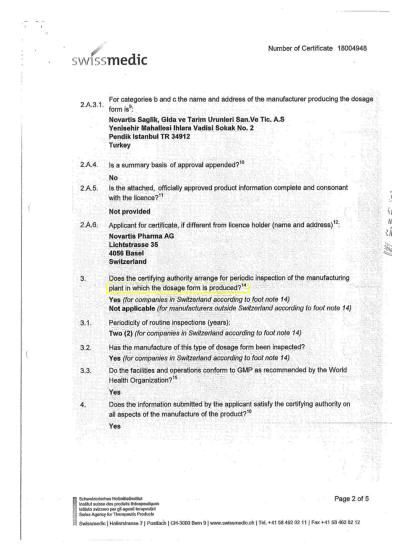

In [53]:
Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

In [20]:
smallTemplate = [(str(area_3), cv2.resize(template_area_3, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA)),
                 (str(area_3_1), cv2.resize(template_area_3_1, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA)),
                 (str(area_3_2), cv2.resize(template_area_3_2, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA)), 
                 (str(area_3_3), cv2.resize(template_area_3_3, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA))]

img_path = Path('/home/huynhtruc0309/Desktop/TEMPLATE_MATCHING/total/2_CPP_Page2/samples/1. NN-34241-page2.jpg')

image = cv2.imread(str(img_path))
%time newHits = matchTemplates(smallTemplate, smallImage, N_object=N_object,score_threshold=score_threshold, method=method, maxOverlap=maxOverlap)


error: OpenCV(4.5.2) /tmp/pip-req-build-oxjbfc17/opencv/modules/imgproc/src/resize.cpp:4057: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [22]:
cv2.resize(template_area_3, smallDim, fx=s, fy=s, interpolation = cv2.INTER_AREA).shape

error: OpenCV(4.5.2) /tmp/pip-req-build-oxjbfc17/opencv/modules/imgproc/src/resize.cpp:4057: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [ ]:
# Format the template into a list of tuple (label, templateImage)
smallTemplate = [("downsampled", smallTemplate)]

%time newHits = matchTemplates(smallTemplate, smallImage, N_object=1, method=cv2.TM_CCOEFF_NORMED)

newHits

In [ ]:
# Cau hoi: Tai sao acc ra 0?